# Object Detection

In this tutorial, you will learn:
- the basic structure of Faster R-CNN.
- to perform inference with a MMDetection detector.
- to train a new detector with a new dataset.

Let's start!


## Install MMDetection

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [4]:
# install dependencies: (use cu111 because colab has CUDA 11.1)
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in links: https://download.pytorch.org/whl/torch_stable.html
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Cloning into 'mmdetection'...
remote: Enumerating objects: 32369, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 32369 (delta 8), reused 10 (delta 1), pack-reused 32338
Receiving objects: 100% (32369/32369), 41.83 MiB | 15.28 MiB/s, done.
Resolving deltas: 100% (23306/23306), done.
C

In [5]:
from mmcv import collect_env
collect_env()

{'sys.platform': 'linux',
 'Python': '3.8.7 (default, Dec 21 2020, 20:10:35) [GCC 7.5.0]',
 'CUDA available': True,
 'GPU 0': 'CUDA GPU',
 'CUDA_HOME': '/usr/local/cuda',
 'NVCC': 'Cuda compilation tools, release 11.1, V11.1.105',
 'GCC': 'x86_64-linux-gnu-gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0',
 'PyTorch': '1.9.0+cu111',
 'PyTorch compiling details': 'PyTorch built with:\n  - GCC 7.3\n  - C++ Version: 201402\n  - Intel(R) Math Kernel Library Version 2020.0.3 Product Build 20200822 for Intel(R) 64 architecture applications\n  - Intel(R) MKL-DNN v2.1.2 (Git Hash 98be7e8afa711dc9b66c8ff3504129cb82013cdb)\n  - OpenMP 201511 (a.k.a. OpenMP 4.5)\n  - NNPACK is enabled\n  - CPU capability usage: AVX2\n  - CUDA Runtime 11.1\n  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,

In [6]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.9.0+cu111 True
2.25.3
11.1
GCC 7.3


## Perform Inference with An MMDet detector



In [7]:
# We download the pre-trained checkpoints for inference and finetuning.
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_s_8x8_300e_coco/yolox_s_8x8_300e_coco_20211121_095711-4592a793.pth \
      -O checkpoints/yolox_s_8x8_300e_coco_20211121_095711-4592a793.pth

--2022-11-10 08:02:57--  https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_s_8x8_300e_coco/yolox_s_8x8_300e_coco_20211121_095711-4592a793.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.75.20.32
Connecting to download.openmmlab.com (download.openmmlab.com)|47.75.20.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36078190 (34M) [application/octet-stream]
Saving to: ‘checkpoints/yolox_s_8x8_300e_coco_20211121_095711-4592a793.pth’

checkpoints/yolox_s 100%[===================>]  34.41M  15.1MB/s    in 2.3s    

2022-11-10 08:03:00 (15.1 MB/s) - ‘checkpoints/yolox_s_8x8_300e_coco_20211121_095711-4592a793.pth’ saved [36078190/36078190]



In [8]:
pwd

'/home/work/Conference/mmdetection'

In [9]:
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

# Choose to use a config and initialize the detector
config = 'configs/yolox/yolox_s_8x8_300e_coco.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoints/yolox_s_8x8_300e_coco_20211121_095711-4592a793.pth'

# Set the device to be used for evaluation
device='cuda:0'

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device) 

# Set the classes of models for inference
model.CLASSES = checkpoint['meta']['CLASSES']

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

load checkpoint from local path: checkpoints/yolox_s_8x8_300e_coco_20211121_095711-4592a793.pth


YOLOX(
  (backbone): CSPDarknet(
    (stem): Focus(
      (conv): ConvModule(
        (conv): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (activate): Swish()
      )
    )
    (stage1): Sequential(
      (0): ConvModule(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (activate): Swish()
      )
      (1): CSPLayer(
        (main_conv): ConvModule(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (activate): Swish()
        )
        (short_conv): ConvModule(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, 

From the printed model, we will find that the model does consist of the components that we described earlier. It uses ResNet as its CNN backbone, and has a RPN head and RoI Head. In addition, the model has a neural network module, named neck, directly after the CNN backbone. It is a [feature pyramid network (FPN)](https://arxiv.org/abs/1612.03144) for enhancing the multi-scale features.


### Inference the detector

Since the model is successfully created and loaded, let's see how good it is. We use the high-level API `inference_detector` implemented in the MMDetection. This API is created to ease the inference process. The details of the codes can be found [here](https://github.com/open-mmlab/mmdetection/blob/master/mmdet/apis/inference.py#L15).

In [10]:
# Use the detector to do inference
img = 'demo/demo.jpg'
result = inference_detector(model, img)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


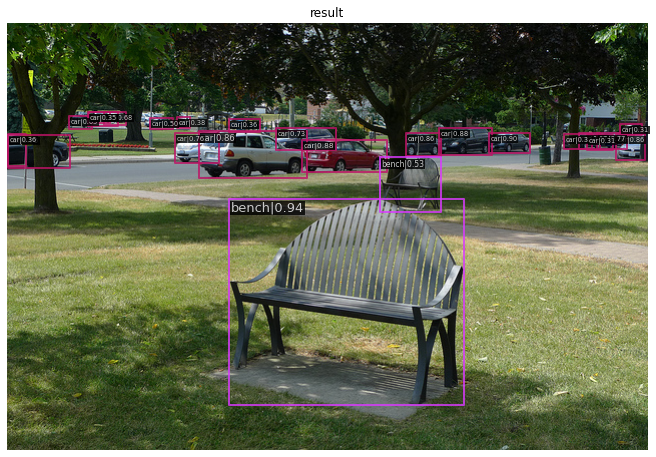

In [11]:
# Let's plot the result
show_result_pyplot(model, img, result, score_thr=0.3)

## Train A Detector on A Customized Dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



### Support a new dataset

There are three ways to support a new dataset in MMDetection: 
  1. Reorganize the dataset into a COCO format.
  2. Reorganize the dataset into a middle format.
  3. Implement a new dataset.

We recommend the first two methods, as they are usually easier than the third one.

In this tutorial, we give an example that converts the data into the formats of existing datasets, e.g. COCO, VOC, etc. Other methods and more advanced usages can be found in the [doc](https://mmdetection.readthedocs.io/en/latest/tutorials/customize_dataset.html#).

First, let's download a tiny dataset obtained from [KITTI](http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=3d). We select the first 75 images and their annotations from the 3D object detection dataset (it is the same dataset as the 2D object detection dataset but with 3D annotations). We convert the original images from PNG to JPEG format with 80% quality to reduce the size of the dataset.

In [12]:
pwd

'/home/work/Conference/mmdetection'

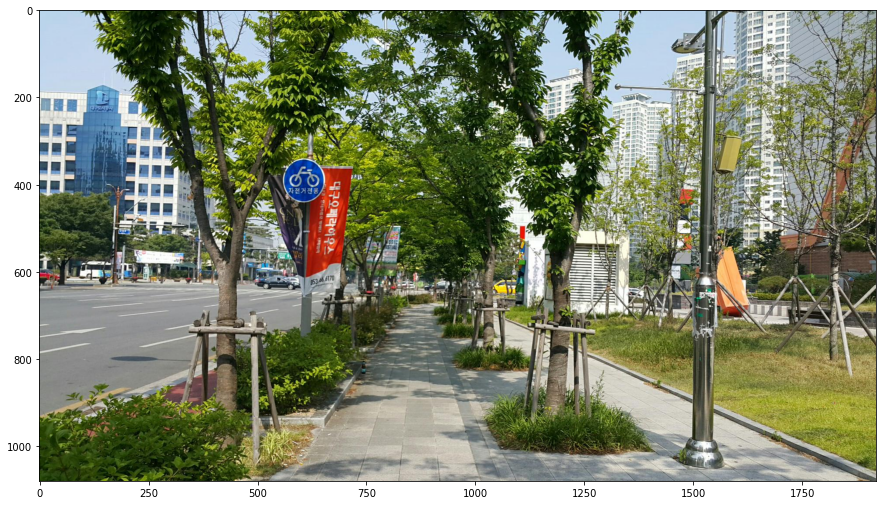

In [13]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('../Bbox2/training/image/MP_SEL_022802.jpg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [14]:
import pickle

with open("../Bbox2/data_infos_2_postprocessing.pkl", "rb") as f:
    data_infos = pickle.load(f)

data_infos

[{'filename': 'MP_SEL_022801.jpg',
  'width': 1920,
  'height': 1080,
  'ann': {'bboxes': array([[  0.  , 477.22,  43.27, 541.18],
          [ 99.9 ,   0.  , 168.46, 618.85],
          [761.71,   0.  , 819.82, 616.97],
          [813.57, 408.68, 853.4 , 448.1 ],
          [  8.95, 607.21,  38.56, 724.54],
          [  0.  , 107.4 ,  47.84, 204.  ],
          [453.7 , 182.1 , 574.91, 857.15],
          [626.25, 289.89, 718.54, 394.06],
          [  0.  , 404.12,  46.01, 476.3 ],
          [  0.  ,   9.87,  48.9 , 106.47]], dtype=float32),
   'labels': array([12,  8,  8, 12,  2, 12, 13, 12, 12, 12], dtype=int32)}},
 {'filename': 'MP_SEL_022802.jpg',
  'width': 1920,
  'height': 1080,
  'ann': {'bboxes': array([[ 559.56,  340.79,  657.03,  441.31],
          [1159.1 ,  571.62, 1222.29,  967.7 ],
          [  93.09,  573.64,  221.9 ,  619.32],
          [1025.25,  616.65, 1132.49,  658.53],
          [ 397.27,  579.51,  463.06, 1036.1 ],
          [1468.  ,    0.  , 1574.6 , 1049.72],
    

In [15]:
import copy
import os.path as osp

import mmcv
import pickle
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module()
class Pavement2Dataset_Yolox(CustomDataset):
    
    CLASSES = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14)
    
    def load_annotations(self, ann_file):

        with open("../Bbox2/data_infos_2_postprocessing.pkl","rb") as f:
            data_infos = pickle.load(f)
            
        for i in range(len(data_infos)):
            data_infos[i]['ann']['labels'] = data_infos[i]['ann']['labels'].astype(np.long)

        return data_infos

In [17]:
from mmcv import Config
cfg = Config.fromfile('configs/yolox/yolox_s_8x8_300e_coco.py')

In [19]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'Pavement2Dataset_Yolox'
cfg.data_root = '../Bbox2/'

cfg.data.test.type = 'Pavement2Dataset_Yolox'
cfg.data.test.data_root = '../Bbox2/'
cfg.data.test.ann_file = 'train.txt'
cfg.data.test.img_prefix = 'training/image'

cfg.data.train.type = 'Pavement2Dataset_Yolox'
cfg.data.train.data_root = '../Bbox2/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/image'

cfg.data.val.type = 'Pavement2Dataset_Yolox'
cfg.data.val.data_root = '../Bbox2/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image'

# modify num classes of the model in box head
cfg.model.bbox_head.num_classes = 15
# If we need to finetune a model based on a pre-trained detector, we need to
# use load_from to set the path of checkpoints.
cfg.load_from = 'checkpoints/yolox_s_8x8_300e_coco_20211121_095711-4592a793.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
optimizer = dict(
    type='SGD',
    lr=0.0025,
    momentum=0.9,
    weight_decay=0.0005,
    nesterov=True,
    paramwise_cfg=dict(norm_decay_mult=0.0, bias_decay_mult=0.0))
optimizer_config = dict(grad_clip=None)
lr_config = dict(
    policy='YOLOX',
    warmup=None,
    by_epoch=False,
    warmup_by_epoch=True,
    warmup_ratio=1,
    warmup_iters=5,
    num_last_epochs=15,
    min_lr_ratio=0.05)
runner = dict(type='EpochBasedRunner', max_epochs=300)
checkpoint_config = dict(interval=12)
log_config = dict(
    interval=10,
    hooks=[dict(type='TextLoggerHook'),
           dict(type='TensorboardLoggerHook')])
custom_hooks = [
    dict(type='YOLOXModeSwitchHook', num_last_epochs=15, priority=48),
    dict(type='SyncNormHook', num_last_epochs=15, interval=10, priority=48),
    dict(
        type='ExpMomentumEMAHook',
        resume_from=None,
        momentum=0.0001,
        priority=49)
]
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = 'checkpoints/yolox_s

In [20]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
cfg.device='cuda'
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

TypeError: Pavement2Dataset_Yolox: __init__() got an unexpected keyword argument 'dataset'

/home/work/Conference/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


TypeError: unsupported operand type(s) for +=: 'int' and 'str'

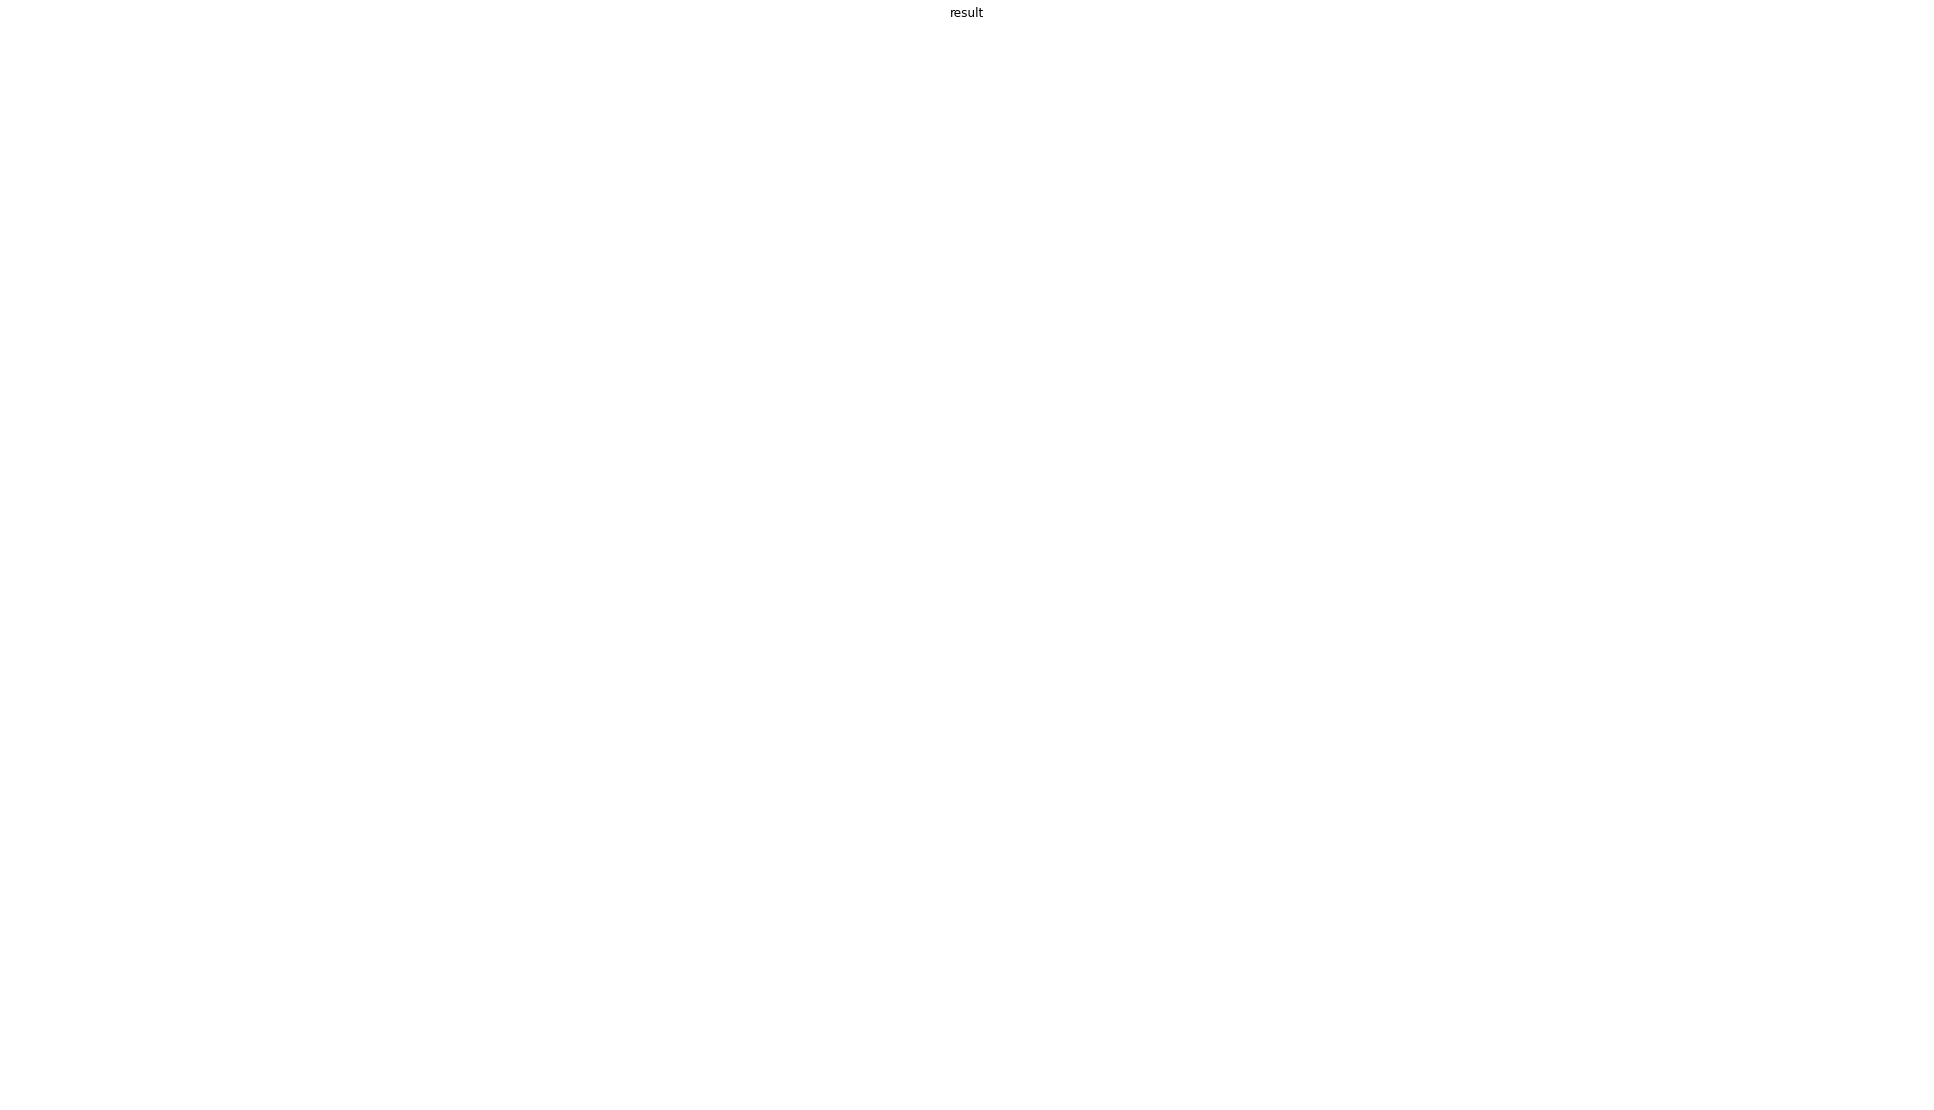

In [28]:
img = mmcv.imread('../Bbox2/training/image/MP_SEL_022844.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

In [29]:
import torch

torch.save(model, '/home/work/Conference/mmdetection/model_bbox2.pt')
torch.save(model.state_dict(), '/home/work/Conference/mmdetection/model_state_dict_bbox2.pt')

In [30]:
model = torch.load('/home/work/Conference/mmdetection/model_bbox2.pt') ;model

FasterRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [32]:
model_state_dict = torch.load('/home/work/Conference/mmdetection/model_state_dict_bbox2.pt') ;model_state_dict

OrderedDict([('backbone.conv1.weight',
              tensor([[[[ 2.8253e-02,  1.8187e-02,  1.5885e-02,  ..., -5.3015e-02,
                         -4.7356e-02,  1.8543e-02],
                        [ 7.9901e-03,  2.4886e-02,  7.6726e-02,  ..., -1.8915e-02,
                         -7.9356e-02, -1.5362e-02],
                        [-2.7473e-02, -6.5754e-02,  1.9992e-02,  ...,  1.1553e-01,
                         -8.9980e-02, -9.4645e-02],
                        ...,
                        [ 2.3180e-02, -4.6452e-02, -1.8301e-01,  ...,  5.3617e-02,
                          8.3496e-02,  3.6958e-02],
                        [ 4.2255e-02,  4.5947e-02, -4.6616e-02,  ..., -2.1024e-02,
                          3.3222e-02,  2.5052e-02],
                        [ 1.4630e-02,  3.5230e-02,  4.1087e-03,  ..., -1.7169e-02,
                          1.1514e-02,  4.7915e-03]],
              
                       [[ 5.8683e-03,  1.8755e-02,  3.6142e-02,  ..., -9.3558e-02,
                       